In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sppl.compilers.spe_to_dict as spe_to_dict
import yaml

from sppl.transforms import Identity as I
from utils import tf

In [2]:
path = "../data"

In [3]:
with open(f"{path}/sppl/merged.json", "r") as f:
    spe = spe_to_dict.spe_from_dict(json.load(f))
    
with open("../params.yaml", "r") as f:
    reweighting_columns = yaml.safe_load(f.read())["reweight_on"]
    
df_LPM_training = pd.read_csv(f"{path}/data.csv")
df_predictions_poststrat = pd.read_csv(f"{path}/predictions.csv")
df_test = pd.read_csv(f"{path}/test.csv")

In [4]:
mkdir -p figs/shifts

In [5]:
lims = [(0.5, 0.75),(0.4, 0.55),(0.35, 0.65)]

def bar(state):
    fig, axes = plt.subplots(ncols=3)
    for i,c in enumerate(df_predictions_poststrat.columns):
        p_model = np.exp(spe.logpdf({I(c):"yes"}))
        df_test_state = df_test[(df_test.state==state) & (~df_test[c].isnull())]
        df_LPM_training_not_null = df_LPM_training[~df_LPM_training[c].isnull()]
        df_predictions_poststrat_state = df_predictions_poststrat.loc[df_test_state.index]
        pmean = df_predictions_poststrat_state[c].mean()
        pmean_us  = df_LPM_training_not_null[c].apply(tf).mean()
        pmean_truth  = df_test_state[c].apply(tf).mean()
        ax = pd.Series([
            pmean_us,
            p_model,
            0, # Leave space between USA version and post-stratified version
            pmean_truth,
            pmean,
            
        ]).plot(
            kind="bar",
            ax=axes[i],
            color=["Darkblue", "Lightblue", "k","Darkgreen", "Lightgreen"]
        )
        ax.set_xticklabels([
            "Empirical\n(USA)", 
            "LPM\n(USA)",
            "",
            f"Empirical\n({state})", 
            f"LPM\n({state})"
        ], rotation=0)
        ax.set_title(c)
        ax.set_ylim(lims[i])
        if i==0:
            ax.set_ylabel("Probability", rotation=0, ha="right")
    fig.set_size_inches(14,3)
    fig.set_tight_layout(True)
    fig.savefig(f"figs/shifts/{state}.jpg", dpi=300)

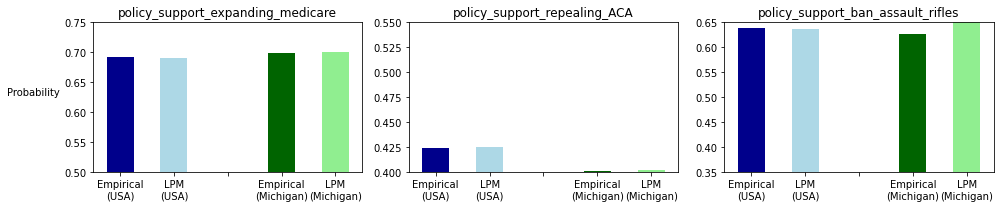

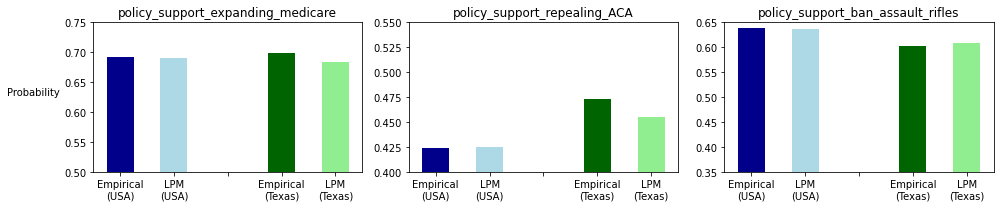

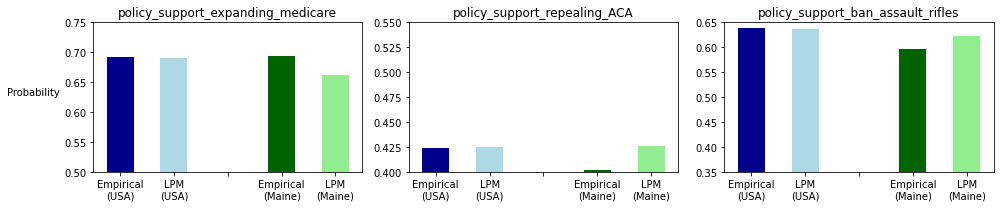

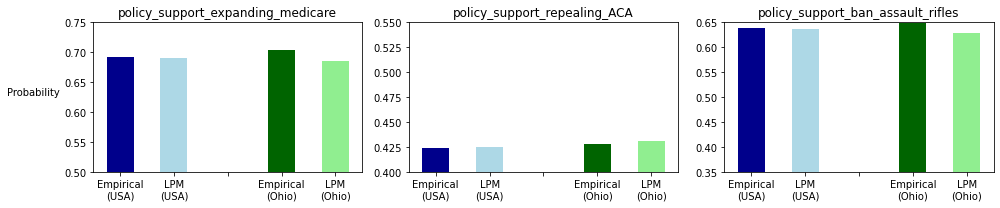

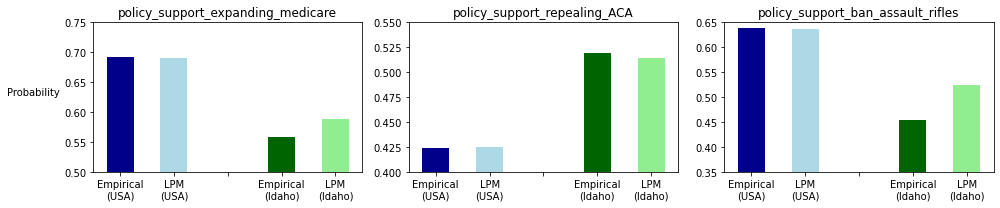

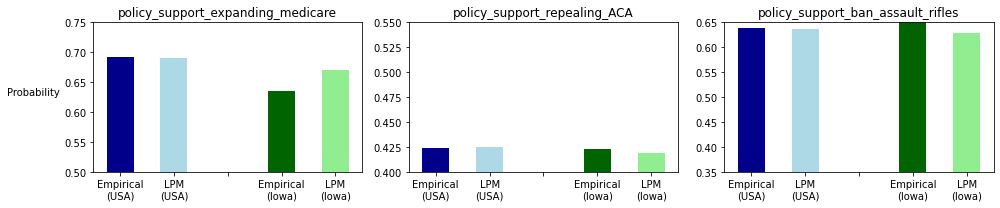

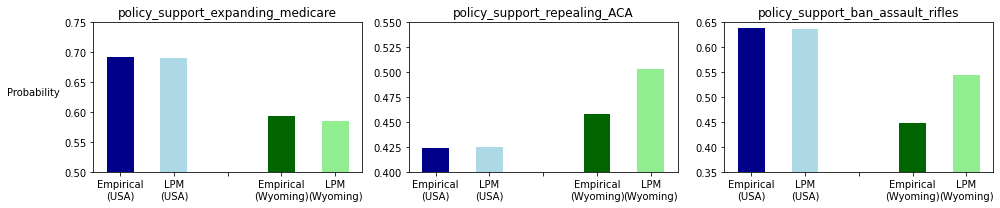

In [6]:
for s in df_test.state.unique():
    bar(s)